In [23]:
import Pkg
Pkg.add(["Plots","Distributions","Random","Polynomials","Statistics","NonlinearSolve","ForwardDiff"])

   Resolving package versions...
  No Changes to `~/Documents/programming/BME-502-2025/Project.toml`
  No Changes to `~/Documents/programming/BME-502-2025/Manifest.toml`


In [32]:
using Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra

# Model Selection

In this chapter we will discuss on how to select between alternative models.  This question often boils down to the question on how many parameters can be supported by a model.  A typical example question would be: How many peaks can we identify in a spectrum?

Before we go into the details, we need to formulate our problem in a Bayesian way:
Let us assume that we want to compare two models or hypothesis $H_1$ and $H_2$.  The first has no parameters and the second one has one parameter $\lambda$.  This argument can be generalized to comparing any two theories with different number of parameters.  To tell which hypothesis is the better one we calculate the posterior ratio:

$$PR = \frac{P(H_{1} \mid D)}{P(H_{2} \mid D)}$$

if PR is greater than one we would prefer $H_1$ over $H_2$, but if PR is on the order unity then the data is not sufficient to make a decision.  We will now use Bayes theorem to get a better sense on how to calculate this ratio.

$$\frac{P(H_{1} \mid D)}{P(H_{2} \mid D)}=\frac{P(D \mid H_{1})}{P(D \mid H_{2})}\frac{P(H_{1})}{P(H_{2})}$$

the nice thing about this ratio is that $P(D)$ cancels because it is the same for both hypothesis.  The last ratio is the ratio of priors and we should probably assume it to be of the order unity.  This is unless there is reason to believe that one hypothesis is more likely to be true then the other one.  This leaves the first ratio.  $P(D\mid H_{1})$ is easy but $P(D\mid H_{2})$ involves a parameter which we can get to by expressing it as

$$P(D \mid H_{2}) = \int P(D, \lambda \mid H_{2})d\lambda = \int P(D \mid \lambda, H_{2})P(\lambda \mid H_{2})d\lambda$$

$P(D \mid \lambda, H_{2})$ is just the likelihood function for hypothesis $H_{2}$ with parameter $\lambda$. $P(\lambda \mid H_{2})$ is the prior an reflects the knowledge of the range of $\lambda$ that is known before the experiment.

Lets now assume that $\lambda$ must lie between two values $\lambda_{min}$ and $\lambda_{max}$ which will assign a uniform prior:

$$P(\lambda \mid H_{2}) = \frac{1}{\lambda_{max}-\lambda_{min}} \quad \textrm{for} \quad \lambda_{min} \le \lambda \le \lambda_{max}$$

after the measurement we will find that a particular value of $\lambda_{0}\pm \delta \lambda$ yields the closest agreement with the data.  The corresponding probability $P(D \mid \lambda_{0},H_{2})$ will be the maximum of $H_{2}$'s likelihood function.  Let us also assume that we can represent the full likelihood as a Gaussian:

$$P(D \mid \lambda, H_{2}) = P(D \mid \lambda_{0},H_{2}) \exp \Big[ -\frac{(\lambda-\lambda_{0})^2}{2\delta \lambda^2} \Big]$$

since the uniform prior does not explicitly depend on $\lambda$ we can calculate

$$P(D \mid H_{2}) = \frac{1}{\lambda_{max}-\lambda_{min}} \int_{\lambda_{min}}^{\lambda_{max}}P(D \mid \lambda, H_{2})$$

Assuming that the vast majority of the Gaussian is contained in the prior interval this reduces to:

$$P(D \mid H_{2}) = \frac{P(D \mid \lambda_{0},H_{2})\delta \lambda \sqrt{2\pi}}{\lambda_{max}-\lambda_{min}} $$

Finally the posterior ratio can be written using three terms:

$$\frac{P(H_{1} \mid D)}{P(H_{2} \mid D)}=\frac{P(H_{1})}{P(H_{2})}\frac{P(D \mid H_{1})}{P(D \mid \lambda_{0},H_{2})}\frac{\lambda_{max}-\lambda_{min}}{\delta \lambda \sqrt{2\pi}}$$

the first term is our bias with respect to the two theories (should be unity), the second tells us about how well the two theories fit the data (this should be in favor of $H_{2}$ since it has a free parameter).  The third term can be seen as penalizing the introduction of the parameter.  Since $\lambda_{max}-\lambda_{min}$ should, in general, be larger than $\delta \lambda \sqrt{2\pi}$ this factor is larger than one.  This factor is often called a Ockham factor after the thirteen-century Franciscan monk William of Ockham (or Occam, in Latin) who said "it is vain to do with more what can be done with fewer".
But instead of blindly applying Ockams razor, we now have a quantitative tool to determine how many paramaters are supported by the data.

We can also generalize this procedure to two models $H_1(\boldsymbol\beta)$ and $H_2(\boldsymbol\lambda)$ that have $k$ and $l$ parameters respectively.  Here we assume that we can fit both models using a model that results in a multivariate Gaussian likelihood function.  For example, if we perform a least-square fit of the data to the model, we can get the best parameters and the covariate matrix $\boldsymbol\Sigma$.
$$\frac{P(H_{1} \mid D)}{P(H_{2} \mid D)}=\frac{P(D \mid \boldsymbol\beta_{0},H_{1})}{P(D \mid \boldsymbol\lambda_{0},H_{2})}\frac{\sqrt{(2\pi)^k |\boldsymbol\Sigma_{H_1}|}}{\sqrt{(2\pi)^l |\boldsymbol\Sigma_{H_2}|}}\frac{\prod_{i=1}^{l}(\lambda_{max.i}-\lambda_{min,i})}{\prod_{i=1}^{k}(\beta_{max.i}-\beta_{min,i})}$$

In [4]:
xdata = range(0, stop=10, length=11)

0.0:1.0:10.0

In [50]:
sigma_y = 3
d = Normal(0,sigma_y)

Normal{Float64}(μ=0.0, σ=3.0)

In [51]:
ydata = 1.0 .+ 2.0 .* xdata + 0.2 .* xdata .^2 + rand(d,length(xdata))

11-element Vector{Float64}:
  2.645165370322875
  6.219266239593074
 13.655448394013561
 13.074632372578435
 16.21226563653135
 16.054708006660082
 22.99476624332888
 20.306722831083484
 31.336649761853323
 38.752126143884894
 39.845954034612554

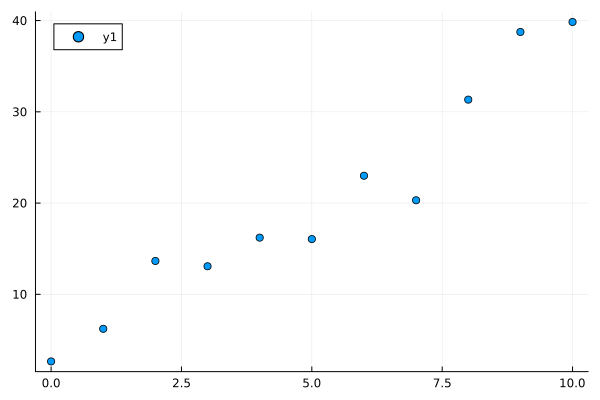

In [52]:
scatter(xdata, ydata)

In [43]:
function lsqfitting(fitfct, (x,y) , sigma, β0)
    res(β,(x,y)) = fitfct(x,β) .- y
    prob = NonlinearLeastSquaresProblem(res, β0, (x,y))
    sol = solve(prob, GaussNewton(); maxiters =1000)
    chi2(β) = sum(abs2, res(β,(x,y)) ./ sigma)
    return sol.u, inv(2*ForwardDiff.hessian(chi2,sol.u)), chi2(sol.u)
end

lsqfitting (generic function with 1 method)

In [44]:
lineareq(x,β) = β[1] .+ β[2] .* x
quadeq(x,β) = β[1] .+ β[2] .* x .+ β[3] .* x .^2

quadeq (generic function with 1 method)

In [53]:
linbeta, lincov, linchi2best = lsqfitting(lineareq, (xdata,ydata), sigma_y, [0.8,2.5])

([2.353170068317384, 3.549324259690387], [0.7159090909090902 -0.10227272727272715; -0.10227272727272717 0.020454545454545437], 11.82831554147156)

In [54]:
quadbeta, quadcov, quadchi2best = lsqfitting(quadeq, (xdata,ydata), sigma_y, [0.8,2.5,0.3])

([4.949403442648116, 1.818502010136565, 0.17308222495538222], [1.3059440559440567 -0.49562937062937146 0.039335664335664426; -0.4956293706293719 0.2826923076923085 -0.026223776223776307; 0.03933566433566448 -0.02622377622377631 0.0026223776223776303], 8.972371346033365)

In [55]:
sqrt.(diag(lincov))

2-element Vector{Float64}:
 0.8461141122266489
 0.14301938838683878

In [56]:
sqrt.(diag(quadcov))

3-element Vector{Float64}:
 1.1427790932389588
 0.5316881677189258
 0.05120915564991899

In [58]:
det(lincov)

0.004183884297520657

In [59]:
det(quadcov)

1.097172455643526e-5

In [57]:
pr = exp(-(linchi2best-quadchi2best)/2)*0.5/sqrt.(diag(quadcov))[3]/sqrt(2*π)

0.9340541463950802

In [65]:
# lets try it with the covariance matrix
sqrt(det(lincov)/det(quadcov))/sqrt(2*π)

7.790448316092572

In [61]:
exp(-(linchi2best-quadchi2best)/2)

0.23979470975133124

In [67]:
# In this case it gives the same result!
pr2 = exp(-(linchi2best-quadchi2best)/2)*sqrt(det(lincov)/det(quadcov))/sqrt(2*π)*0.5

0.9340541463950829